<a href="https://colab.research.google.com/github/daa103/DAA_ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_ch4_4_pg_182~200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**04 위성이미지 분류**
**4-1 텐서플로 데이터셋 로드**

In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

In [2]:
# EuroSAT 위성 사진 데이터셋 로드

DATA_DIR = "/content/dataset"

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True, as_supervised=True, with_info=True, data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /content/dataset/eurosat/rgb/2.0.0.incompleteVZGPTB/eurosat-train.tfrecord*...:   0%|          | 0/2…

Dataset eurosat downloaded and prepared to /content/dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [3]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir=PosixGPath('/tmp/tmpr_y3qok3tfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('ima

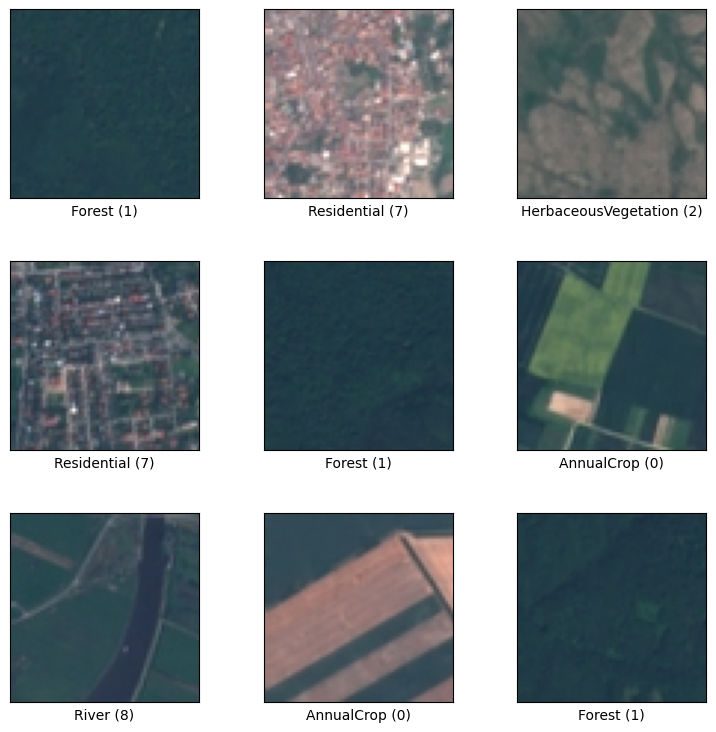

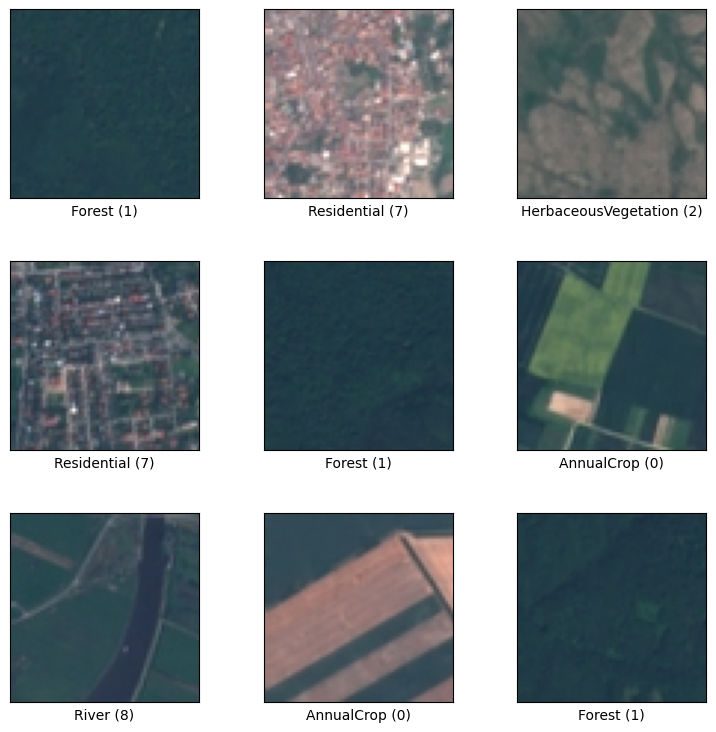

In [4]:
# 데이터 확인
tfds.show_examples(train_ds, info)

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

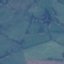
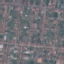
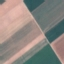
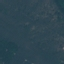
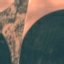
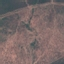
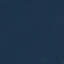
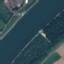
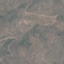
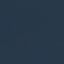

In [5]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [6]:
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


In [7]:
# 숫자 레이블을 활용하여 문자열 메타 데이터로 변환
print(info.features["label"].int2str(6))

PermanentCrop


**4-2 데이터 전처리**
- 텐서플로 데이터셋을 사용하면 딥러닝 데이터셋을 쉽게 구할 수 잇고 전처리 과정이 쉽다.

In [8]:
# 데이터 전처리 파이프라인
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

**4-3 모델 훈련 및 검증**
- 정규화 합성곱 풀링 레이어로 구성된 유닛 2개를 연결하고, Dense레이어와 Dropout으로 구성된 최종 분류기를 갖는 딥러닝 모델을 Sequetial API로 생성.

In [9]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

  model = tf.keras.Sequential([

      # Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model

model = build_model()

In [10]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=50)

Epoch 1/50
338/338 [==============================] - 274s 794ms/step - loss: 1.6019 - accuracy: 0.4469 - val_loss: 1.6494 - val_accuracy: 0.4526
Epoch 2/50
338/338 [==============================] - 214s 630ms/step - loss: 1.2174 - accuracy: 0.5747 - val_loss: 0.9570 - val_accuracy: 0.6643
Epoch 3/50
338/338 [==============================] - 236s 698ms/step - loss: 1.0455 - accuracy: 0.6344 - val_loss: 0.7607 - val_accuracy: 0.7646
Epoch 4/50
338/338 [==============================] - 200s 592ms/step - loss: 0.9471 - accuracy: 0.6659 - val_loss: 0.7519 - val_accuracy: 0.7511
Epoch 5/50
338/338 [==============================] - 200s 592ms/step - loss: 0.8616 - accuracy: 0.7030 - val_loss: 0.5958 - val_accuracy: 0.8089
Epoch 6/50
338/338 [==============================] - 198s 587ms/step - loss: 0.7986 - accuracy: 0.7297 - val_loss: 0.5690 - val_accuracy: 0.8094
Epoch 7/50
338/338 [==============================] - 200s 592ms/step - loss: 0.7196 - accuracy: 0.7549 - val_loss: 0.5697 -

In [11]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

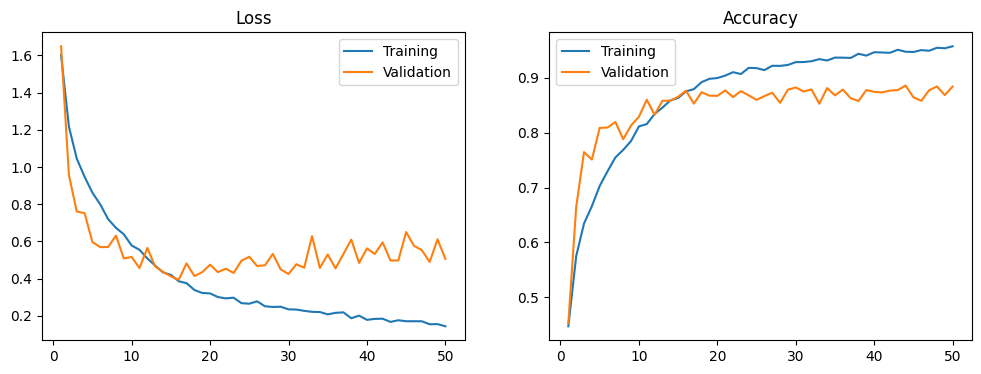

In [12]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history, 50)

**4-4 데이터 증강**

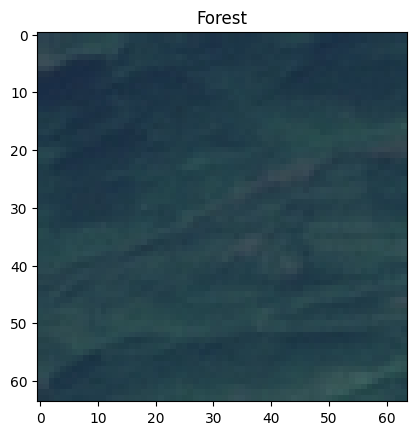

In [13]:
# 샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [14]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

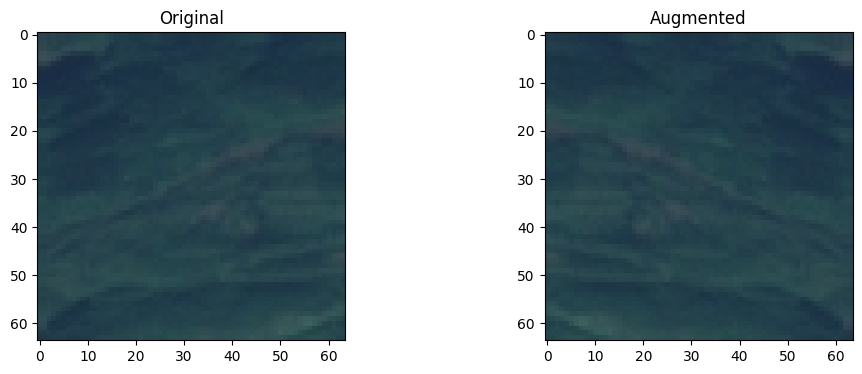

In [15]:
# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

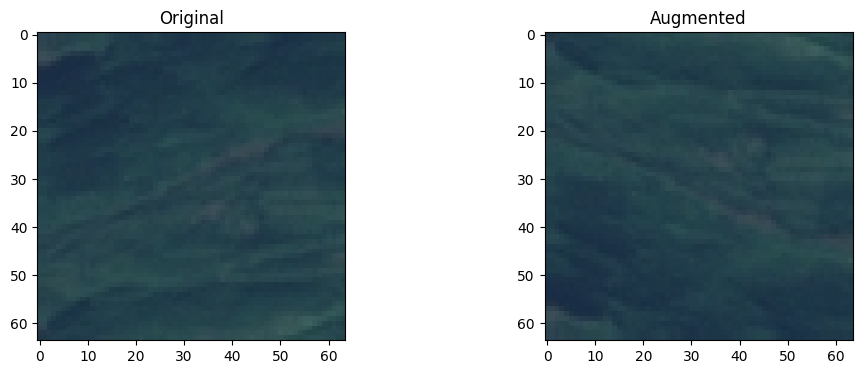

In [16]:
# 상하 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

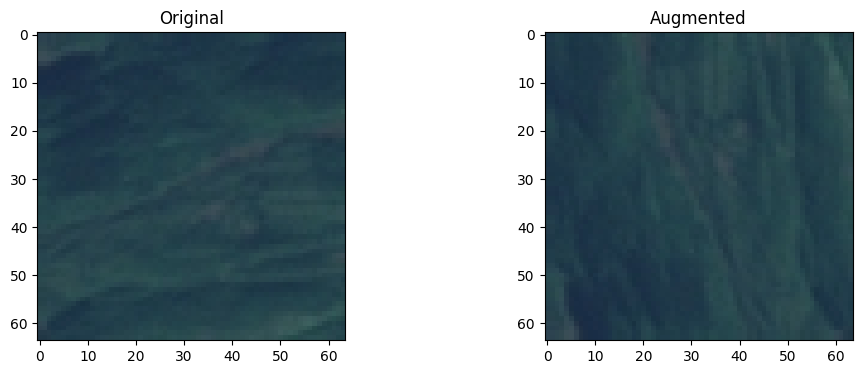

In [17]:
# 반시계 방향 90도 회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

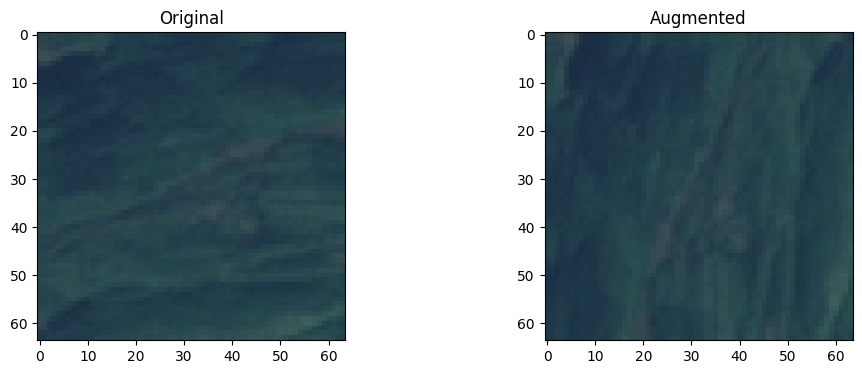

In [18]:
# 이미지 텐서 행렬의 도치
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

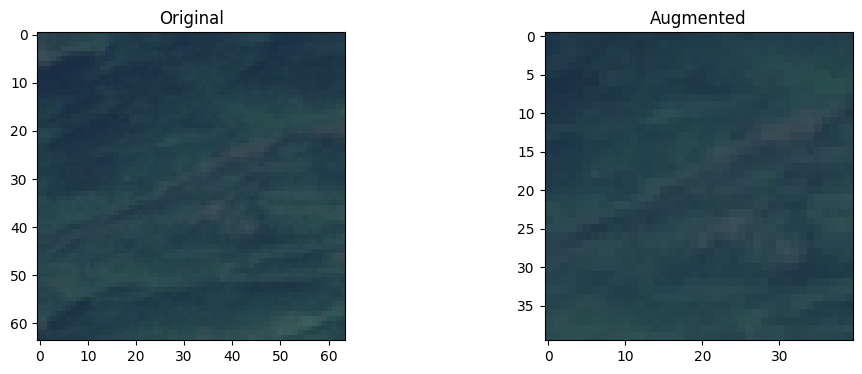

In [19]:
# 이미지의 중심에서 일정 부분 자르기
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

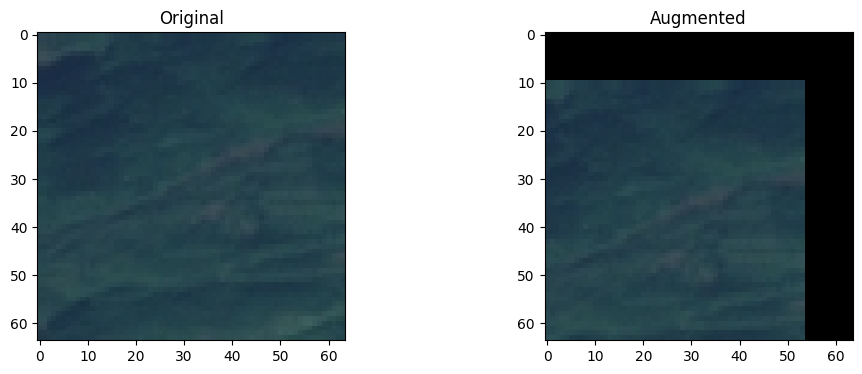

In [20]:
# 원본 이미지가 상하좌우 랜덤한 방향으로 시프트 이동
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

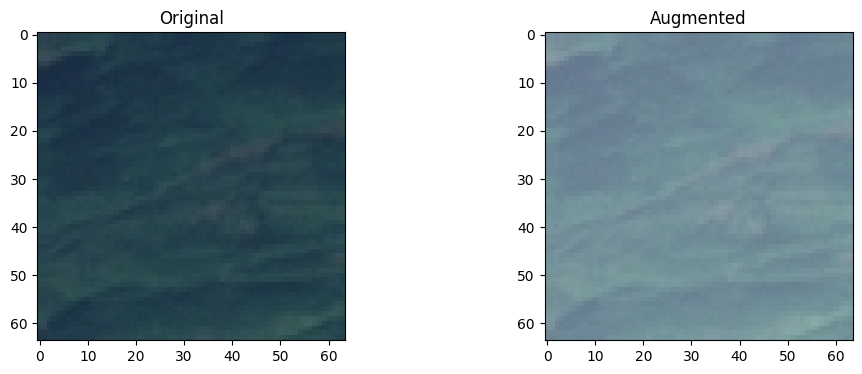

In [21]:
# 이미지 밝기 직접 조정
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

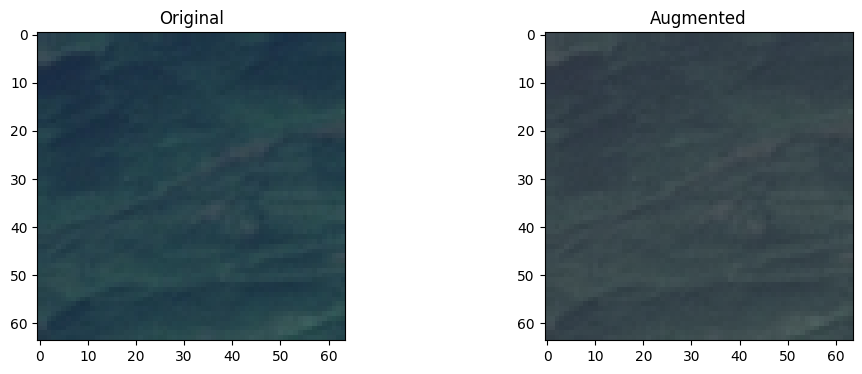

In [22]:
# 이미지 채도 변경
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

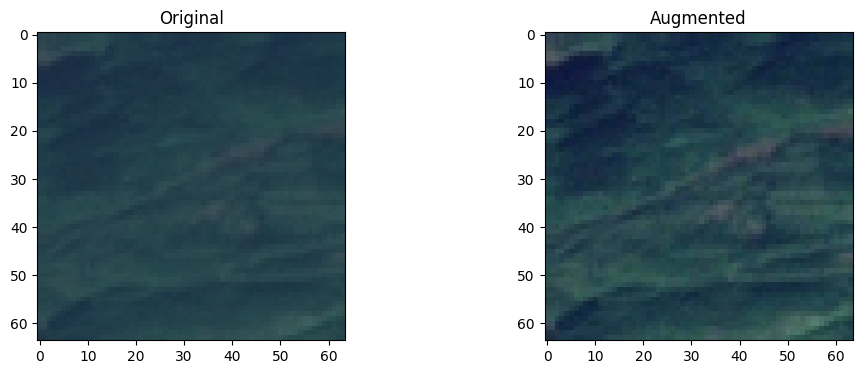

In [23]:
# 이미지 대비 조정
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [24]:
# 이미지 증강 전처리
def data_augmentation(image, label):

    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug,
                            validation_data = valid_aug,
                            epochs = 50)

Epoch 1/50
338/338 [==============================] - 222s 653ms/step - loss: 1.9091 - accuracy: 0.2985 - val_loss: 1.8125 - val_accuracy: 0.3569
Epoch 2/50
338/338 [==============================] - 196s 578ms/step - loss: 1.5595 - accuracy: 0.4112 - val_loss: 1.3129 - val_accuracy: 0.5050
Epoch 3/50
283/338 [========================>.....] - ETA: 30s - loss: 1.4020 - accuracy: 0.4715

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 50)

**4-5 ResNet 사전 학습모델**

위성이미지 분류를 ResNet모델을 활용한다.

In [ ]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                               weights='imagenet',
                               input_shape=[64, 64, 3])

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

In [ ]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

  model = tf.keras.Sequential([

      # Pre-trained Base
      pre_trained_base,
      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model

# 모델 구조
tc_model = build_trainsfer_classifier()
tc_model.summary()